In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, auc, roc_auc_score, plot_confusion_matrix, SCORERS, plot_roc_curve, classification_report, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_score

In [38]:
test_titanic = pd.read_csv('../data/test.csv')  
train_titanic = pd.read_csv('../data/train.csv')  

In [39]:
test_titanic.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [40]:
train_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
df_titanic = train_titanic[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Parch', 'SibSp']]

In [42]:
percentage_per_column_missing_value = df_titanic.isnull().sum() * 100 / len(df_titanic)
percentage_per_column_missing_value

Survived     0.00000
Pclass       0.00000
Sex          0.00000
Age         19.86532
Fare         0.00000
Parch        0.00000
SibSp        0.00000
dtype: float64

In [43]:
df_titanic.shape

(891, 7)

In [44]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
Fare        891 non-null float64
Parch       891 non-null int64
SibSp       891 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


# Create X and y dataframes, split them into train and test, get the list of categorical and numeric features.

In [58]:
y = df_titanic.Survived
X = df_titanic.drop(['Survived'], axis=1)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

categorical_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "object"]
numeric_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "int64" or X_train[cname].dtype == "float64"]

In [59]:
numeric_features

['Pclass', 'Age', 'Fare', 'Parch', 'SibSp']

# Preprocess the training data, create the classifier model and fit it with the data.

In [86]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=0))])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Parch', 'SibSp']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex'])])),
                ('classifier', LogisticRegression(random_state=0))])

# Get an extended list of numeric features, with the One Hot encoded categorical features.

In [63]:
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [64]:
numeric_features_list

['Pclass', 'Age', 'Fare', 'Parch', 'SibSp', 'Sex_female', 'Sex_male']

# CROSS VALIDATION 

La cross validation permet de calculer un paramètres à différents endroits que l'on appelle plis de la data. On peut ensuite calculer une moyenne de l'ensemble des "plis" pour arriver à un score plus représentatif de la réalité de la dataset. 

In [71]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.77622378, 0.8041958 , 0.73239437, 0.8028169 , 0.83802817])

In [73]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.04


Par défaut, la cross validation nous calcule l'"accuracy". La "standard deviation" signifie l'écart-type c'est à dire la racine carré de la variance. 

Étant donné notre modèle de classification, nous décidons de calculer certaines metrics de la régression logistique en utilisant la cross validation pour plus de précision. 

In [69]:
f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
roc_auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
precision_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')

#On distingue bien les 5 plis par hyperparamètres
print(f1_scores)
print(precision_scores)
print(recall_scores)
print(roc_auc_scores)

[0.68627451 0.74074074 0.64150943 0.7254902  0.78095238]
[0.74468085 0.75471698 0.65384615 0.77083333 0.82      ]
[0.63636364 0.72727273 0.62962963 0.68518519 0.74545455]
[0.81332645 0.88347107 0.79124579 0.85364057 0.89989551]


In [74]:
print("Average F1 scores: %.3f\n" % f1_scores.mean())
print("Average roc auc scores: %.3f\n" % roc_auc_scores.mean())
print("Average Precision scores: %.3f\n" % precision_scores.mean())
print("Average Recall scores: %.3f\n" % recall_scores.mean())

Average F1 scores: 0.715

Average roc auc scores: 0.848

Average Precision scores: 0.749

Average Recall scores: 0.685



# VALIDATION CURVE

In [76]:
from sklearn.model_selection import validation_curve

Une courbe de validation est utilisée pour évaluer un modèle existant basé sur des hyper-paramètres .

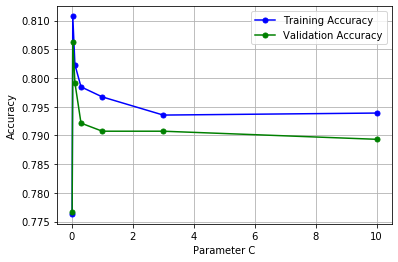

In [92]:
# Get Training and test scores using validation curve method
# Pay attention to the parameter values range set as param_range
#
param_range = [0.01, 0.03,0.1, 0.3, 1, 3, 10]
train_scores, test_scores = validation_curve(estimator=clf,
                                             X=X_train, y=y_train,
                                             cv=5,
param_name='classifier__C', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
#
# Plot the model scores (accuracy) against the paramater range
#
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', 
         label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', 
         label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.grid()
plt.show()

    Idéalement, nous voudrions que la courbe de validation et la courbe d'entraînement soient aussi similaires que possible.
    
    Si les deux scores sont faibles, le modèle sera probablement "underfitting". Cela signifie que le modèle est trop simple ou qu'il est informé par trop peu de fonctionnalités. Il se peut également que le modèle soit trop régularisé.
    
    Si la courbe d'entraînement atteint un score élevé relativement rapidement et que la courbe de validation est à la traîne, le modèle est "overfitting". Cela signifie que le modèle est très complexe et qu'il y a trop peu de données.
    
    Nous voudrions la valeur du paramètre où les courbes d'apprentissage et de validation sont les plus proches l'une de l'autre. 

# GRIDSEARCH

Gridsearch permet une recherche des meilleurs paramètres. 

In [94]:


param_grid = {
    'classifier__C': param_range,

}


grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'Fare',
                                                                          'Parch',
                                                                          'Sib

In [95]:
grid_search.best_params_

{'classifier__C': 0.03}

In [96]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'Parch', 'SibSp']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex'])])),
                ('classifier', LogisticRegression(C=0.03, random_state=0))])